# Import Data

In [93]:
import numpy as np
from netCDF4 import Dataset
directory="/Users/lambda/Documents/Code/CaliforniaDrought2016/Data/"
#file=directory+"Pressure/hgt.mon.mean.nc"
#nc=Dataset(file,'r')
#pressure=nc.variables["hgt"][0:816,7,0:48,48:112]
file=directory+"Pressure/slp.mon.mean.nc"
nc=Dataset(file,'r')
#pressure=nc.variables["slp"][0:815,0:48,48:112]
pressure=nc.variables["slp"][0:816,0:48,48:112]
lat=nc.variables["lat"][:]
lon=nc.variables["lon"][:]
from numpy import loadtxt
CAMonthTotal= loadtxt(directory+'Precipitation/CAMonthTotal.txt')
ORMonthTotal= loadtxt(directory+'Precipitation/ORMonthTotal.txt')
WCMonthTotal= loadtxt(directory+'Precipitation/WCMonthTotal.txt')
CAMonthTotal=CAMonthTotal.reshape((816, 1))
ORMonthTotal=ORMonthTotal.reshape((816, 1))
WCMonthTotal=WCMonthTotal.reshape((816, 1))
CAMonthTotal=CAMonthTotal[0:816,:]
rlat=48
rlon=64

In [94]:
y_data=CAMonthTotal
x=pressure[0:3,:,:]
y=y_data[0:3,:]
for i in range(len(CAMonthTotal)/12):
    x=np.append(x,pressure[10+12*i:15+12*i,:,:],axis=0)
    y=np.append(y,y_data[10+12*i:15+12*i,:],axis=0)
l=len(x)
x_data=x.flatten()
y_data=y
x_data=np.reshape((x_data-np.mean(x_data))/np.std(x_data),(l,rlat,rlon,1))
y_data=(y_data-np.mean(y_data))/np.std(y_data)

# Set Computing Graph

### HyperParameters

In [95]:
ptraining=240
ctraining=[]
ctest=[]
#Convolution Layer Parameters
wc1=5
nc1=3
wc2=5 
nc2=1
wp1=2
wp2=2
fl=(rlat-wc1-wc2-wp1-wp2+4)*(rlon-wc1-wc2-wp1-wp2+4)*nc2
wfc=50
wfc2=10

### Graph

In [96]:
import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder('float', [None, rlat,rlon,1])
y = tf.placeholder('float',[None,1])
def convolutional_neural_network(x):
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')
    def maxpool2d(x,W):
        return tf.nn.max_pool(x, [1,W,W,1], strides=[1,1,1,1], padding='VALID')
    weights = {'W_conv1':tf.Variable(tf.random_normal([wc1,wc1,1,nc1],stddev=0.0001,name="W_conv1")),
               'W_conv2':tf.Variable(tf.random_normal([wc2,wc2,nc1,nc2],stddev=0.0001)),
               'W_fc':tf.Variable(tf.random_normal([fl,wfc],stddev=0.0001)),
               'W_fc2':tf.Variable(tf.random_normal([wfc,wfc2],stddev=0.0001)),
               'out':tf.Variable(tf.random_normal([wfc2, 1],stddev=0.0001))}

    biases = { 'b_conv1':tf.Variable(tf.random_normal([nc1],stddev=0.001)),
               'b_conv2':tf.Variable(tf.random_normal([nc2],stddev=0.001)),
               'b_fc':tf.Variable(tf.random_normal([wfc],stddev=0.001)),
               'b_fc2':tf.Variable(tf.random_normal([wfc2],stddev=0.001)),
               'out':tf.Variable(tf.random_normal([1],stddev=0.001))}
     
    
    conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1']
    pool1 = maxpool2d(conv1,wp1)

    conv2 = conv2d(pool1, weights['W_conv2']) + biases['b_conv2']
    pool2 = maxpool2d(conv2,wp2)

    fc = tf.reshape(pool2,[-1, fl])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc2 = tf.nn.relu(tf.matmul(fc, weights['W_fc2'])+biases['b_fc2'])
    output = tf.matmul(fc2, weights['out'])+biases['out'] 
    return output

In [97]:
prediction = convolutional_neural_network(x)
cost = tf.reduce_mean(tf.square(prediction-y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
all_saver = tf.train.Saver()

# Train

In [98]:
def train_neural_network(x):
    gtestcost=np.inf
    batch=120
    epoches=300
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoches):
            for b in range(ptraining/batch):
                epoch_x=x_data[b*batch:(b+1)*batch,:,:,:]
                epoch_y=y_data[b*batch:(b+1)*batch,:]
                sess.run(optimizer, feed_dict={x: epoch_x, y: epoch_y})
                trainingcost=sess.run(cost, feed_dict={x: epoch_x, y: epoch_y})
                ctraining.append(trainingcost)
            testcost=sess.run(cost, feed_dict={x: x_data[ptraining:,:,:,:], 
                                                   y: y_data[ptraining:,:]})
            print testcost
            if testcost < gtestcost and (testcost<0.25):
                gtestcost=testcost
                all_saver.save(sess, 'CNN_Trained')
            ctest.append(testcost)
        result=sess.run(prediction,feed_dict={x: x_data})
        sess.close()
    return result

In [99]:
tf.set_random_seed(5)
train_neural_network(x)

0.870682
0.871117
0.871566
0.872031
0.872513
0.873016
0.873546
0.874059
0.874326
0.874061
0.872748
0.869303
0.863
0.853777
0.841533
0.825631
0.816057
0.823943
0.84582
0.800724
0.78978
0.827101
0.766539
0.73261
0.715318
0.686241
0.646507
0.599662
0.554156
0.497343
0.434476
0.382427
0.346386
0.335081
0.302692
0.283514
0.286834
0.286166
0.301629
0.304143
0.319286
0.304927
0.298765
0.29228
0.281761
0.290308
0.288134
0.275788
0.276138
0.273546
0.272232
0.280981
0.283537
0.268293
0.255339
0.276144
0.308032
0.256576
0.245689
0.308844
0.25015
0.272083
0.261009
0.246336
0.277384
0.246555
0.270062
0.254518
0.250519
0.271038
0.250736
0.261614
0.268365
0.251202
0.260282
0.274044
0.259665
0.253037
0.277256
0.286795
0.252446
0.247596
0.321461
0.268691
0.253417
0.327198
0.24917
0.294964
0.277856
0.263949
0.306086
0.26637
0.314133
0.287381
0.286119
0.312542
0.288854
0.312188
0.308992
0.291606
0.314806
0.316933
0.299839
0.31008
0.332698
0.310808
0.293642
0.326516
0.350651
0.301969
0.297286
0.370529
0.3

array([[ -8.58652651e-01],
       [ -7.24934697e-01],
       [  1.82557896e-01],
       [ -9.80128884e-01],
       [  9.93718505e-02],
       [ -5.90242803e-01],
       [ -5.67410141e-04],
       [  4.49549794e-01],
       [ -5.08619905e-01],
       [ -5.40276706e-01],
       [  9.87457693e-01],
       [ -1.44400686e-01],
       [ -2.58268893e-01],
       [  4.70348209e-01],
       [  3.69447619e-01],
       [  3.63392204e-01],
       [ -3.41135174e-01],
       [ -8.63841772e-01],
       [ -8.97451639e-02],
       [  1.66763902e+00],
       [  1.74678063e+00],
       [ -8.01554918e-02],
       [  5.70440829e-01],
       [ -2.78309286e-01],
       [  1.71168232e+00],
       [  5.83720922e-01],
       [ -1.24905968e+00],
       [ -4.50221390e-01],
       [  1.59371905e-02],
       [ -1.01931715e+00],
       [  1.02149248e+00],
       [  4.47957420e+00],
       [  3.22602540e-01],
       [ -3.18305403e-01],
       [  7.98421204e-02],
       [  7.45128393e-02],
       [ -8.63858759e-01],
 

In [100]:
[np.min(ctest),np.min(ctraining)]

[0.24568869, 0.014324339]

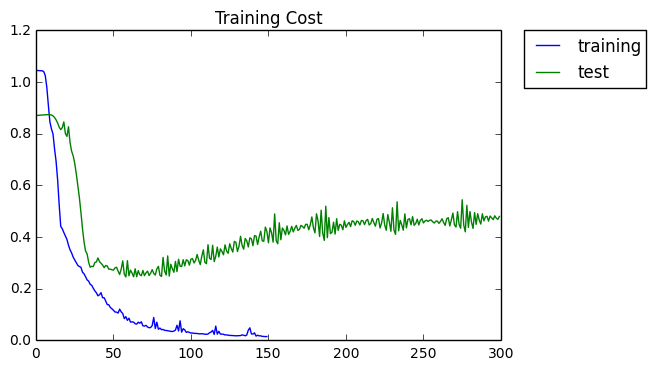

In [101]:
import matplotlib.pyplot as plt
plt.plot(ctraining[0:800:4], label="training")
plt.plot(ctest,label="test")
plt.title("Training Cost")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Result

In [103]:
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    # Restore model weights from previously saved model
    load_path =all_saver.restore(sess, '/Users/lambda/Documents/Code/Lib/TensorFlow/CNN_Trained')
    trainingresult=sess.run(prediction,feed_dict={x:x_data[0:ptraining,:,:,:]})
    testresult=sess.run(prediction,feed_dict={x:x_data[ptraining:,:,:,:]})

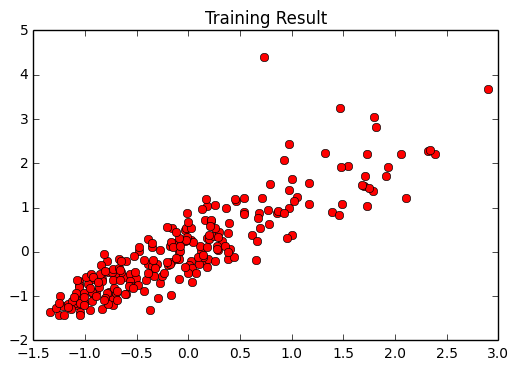

In [104]:
import matplotlib.pyplot as plt
plt.plot(trainingresult,y_data[0:ptraining,:],'ro')
plt.title("Training Result")
plt.show()

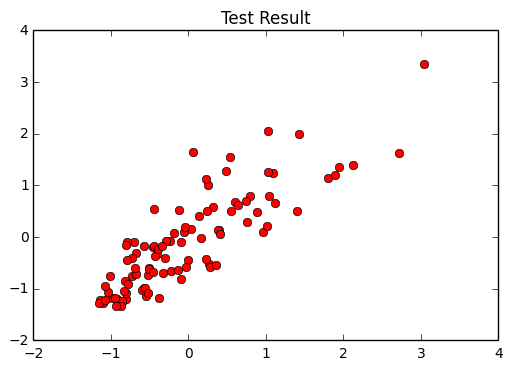

In [105]:
import matplotlib.pyplot as plt
plt.plot(testresult,y_data[ptraining:,:],'ro')
plt.title("Test Result")
plt.show()

In [106]:
np.corrcoef(map(lambda x:x[0],trainingresult[0:ptraining].tolist()),
            map(lambda x:x[0],y_data[0:ptraining,:][0:ptraining].tolist()))[0][1]

0.8862166750511461

In [107]:
np.corrcoef(map(lambda x:x[0],testresult[0:240].tolist()),
         map(lambda x:x[0],y_data[ptraining:,:].tolist()))[0][1]

0.85357051147777685

In [108]:
map(lambda m:np.corrcoef(map(lambda x:x[0],trainingresult[m:ptraining:12].tolist()),
                         map(lambda x:x[0],y_data[0:ptraining,:][m:ptraining:12].tolist()))[0][1],
    range(12))

[0.91738260880152744,
 0.86292725528473102,
 0.80608595383684722,
 0.93386113692397943,
 0.88760842273133223,
 0.92466962297190702,
 0.86191934356091948,
 0.84742639719268997,
 0.9271526870621527,
 0.89698780769030617,
 0.92215490824770574,
 0.95161881780544233]

In [109]:
map(lambda m:np.corrcoef(map(lambda x:x[0],testresult[m:240:12].tolist()),
                         map(lambda x:x[0],y_data[ptraining:,:][m:ptraining:12].tolist()))[0][1],
    range(12))

[0.73481582327270323,
 0.70673855267344132,
 0.91772788805392302,
 0.77000822601789043,
 0.86732928840950307,
 0.85778087611426757,
 0.83743175785467283,
 0.79381507337753565,
 0.60444102496315888,
 0.90104750393494748,
 0.87944141976718893,
 0.97629486036801283]